
# Visual Analytics for Trust and Resilience in Satellite–Terrestrial Integrated Networks (STINs)
### **Revised Colab-ready notebook** (public NASA CMR metadata)

This notebook is a **visual-first** experimental pipeline for analyzing **integrity**, **trust dynamics**, and **overheads** in STIN exchanges.

**What you get**
- Robust NASA CMR metadata ingestion (**2-step**: collections → granules)
- Ledger-style commitments using **SHA3-256** with hash chaining
- Attack injection (post-commitment tampering) and deterministic detection
- Trust score evolution and rolling stability metrics
- **Visual analytics**: annotated plots, overlays, composite storytelling view
- One-click figure export for manuscript-ready images

> Tip: Run from top to bottom. All figures are saved in `Figures/`.



## 0) Environment setup (Google Colab)

This notebook runs on Google Colab with standard Python packages.
We install a small set of extra dependencies for convenience.


In [ ]:

# Install lightweight dependencies (Colab)
!pip -q install requests pandas numpy matplotlib scipy


In [ ]:
# Figure generation switches (for the Visual Analytics paper)
GENERATE_QS_FIGURES = False   # legacy QS-STIN metric figures (Article 1) - disabled to avoid reuse
GENERATE_VA_FIGURES = True    # new integrative Visual Analytics figures (Article 2)

OFFLINE_MODE = True  # enabled for artifact generation in this environment



## 1) Reproducibility controls

We fix seeds and create output folders.


In [ ]:

import os, json, time, random, hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

os.makedirs("Figures", exist_ok=True)
print("Ready. Figures will be saved to: ./Figures")


Ready. Figures will be saved to: ./Figures



## 2) Load public NASA metadata via CMR (robust 2-step method)

Some combinations of query parameters can trigger **HTTP 400** on the granules endpoint.
A robust approach is:

1) Search **collections** using `keyword=...`  
2) Choose a `collection_concept_id`  
3) Query **granules** using `collection_concept_id=...`

This avoids the issue you encountered.


In [ ]:

import requests
import pandas as pd

CMR_COLLECTIONS_URL = "https://cmr.earthdata.nasa.gov/search/collections.json"
CMR_GRANULES_URL     = "https://cmr.earthdata.nasa.gov/search/granules.json"

# Offline mode helper: if the runtime has no internet access, enable OFFLINE_MODE=True.
try:
    OFFLINE_MODE
except NameError:
    OFFLINE_MODE = False

def _synthetic_cmr_collections(keyword="MODIS"):
    return {"feed": {"entry": [{"short_name": f"{keyword}_OFFLINE",
                                "id": "C00000000",
                                "title": f"Offline synthetic collection for {keyword}"}]}}

def _synthetic_cmr_granules(n=200, product="MODIS"):
    from datetime import datetime, timedelta
    base = datetime(2025, 1, 1, 0, 0, 0)
    entries=[]
    for i in range(n):
        t0 = base + timedelta(minutes=15*i)
        t1 = t0 + timedelta(minutes=5)
        entries.append({
            "title": f"{product}_GRANULE_{i:05d}",
            "id": f"G{i:08d}",
            "updated": (t0 + timedelta(hours=3)).isoformat()+"Z",
            "provider_id": "OFFLINE_PROVIDER",
            "time_start": t0.isoformat()+"Z",
            "time_end": t1.isoformat()+"Z",
        })
    return {"feed": {"entry": entries}}

def cmr_search_collections(keyword="MODIS", page_size=20):
    """Search NASA CMR collections by keyword."""
    if OFFLINE_MODE:
        return _synthetic_cmr_collections(keyword)
    params = {"keyword": keyword, "page_size": page_size}
    r = requests.get(CMR_COLLECTIONS_URL, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def list_collections(collections_json, max_show=10):
    entries = collections_json.get("feed", {}).get("entry", [])
    rows=[]
    for e in entries[:max_show]:
        rows.append({
            "short_name": e.get("short_name"),
            "concept_id": e.get("id"),
            "title": e.get("title")
        })
    return pd.DataFrame(rows)

def pick_collection(collections_json, prefer_short_name=None):
    """Pick a collection concept-id from candidates."""
    entries = collections_json.get("feed", {}).get("entry", [])
    if not entries:
        return None
    if prefer_short_name:
        for e in entries:
            if e.get("short_name","").upper() == prefer_short_name.upper():
                return e.get("id")
    return entries[0].get("id")

def cmr_search_granules(keyword="MODIS", collection_concept_id=None, page_size=200):
    """Search CMR granules; uses keyword if collection id is absent."""
    if OFFLINE_MODE:
        return _synthetic_cmr_granules(n=page_size, product=keyword)
    params = {"page_size": page_size, "sort_key": "-start_date"}
    if collection_concept_id:
        params["collection_concept_id"] = collection_concept_id
    else:
        # CMR supports keyword for granules search; keep it for simplicity
        params["keyword"] = keyword
    r = requests.get(CMR_GRANULES_URL, params=params, timeout=30)
    r.raise_for_status()
    return r.json()


def pick_collection_concept_id(collections_json, prefer_short_name_contains=None):
    """Return (collection_concept_id, short_name)"""
    entries = collections_json.get("feed", {}).get("entry", [])
    if not entries:
        return None, None
    if prefer_short_name_contains:
        token = prefer_short_name_contains.upper()
        for e in entries:
            if token in (e.get("short_name","").upper() + " " + e.get("title","").upper()):
                return e.get("id"), e.get("short_name")
    e = entries[0]
    return e.get("id"), e.get("short_name")


def cmr_search_granules_by_collection(collection_concept_id, page_size=200):
    return cmr_search_granules(keyword="MODIS", collection_concept_id=collection_concept_id, page_size=page_size)



### 2.1 Execute CMR query

If you want a different dataset than MODIS, change the keyword below (e.g., `Landsat`, `Sentinel`, `VIIRS`, `SMAP`, `ICESat`).


In [ ]:

# Step 1: Find collections related to a keyword
KEYWORD = "MODIS"     # <-- change if desired
COLLECTIONS_PAGE_SIZE = 25
GRANULES_PAGE_SIZE = 200

collections = cmr_search_collections(keyword=KEYWORD, page_size=COLLECTIONS_PAGE_SIZE)

# Optional: inspect candidates (first 10)
cand = list_collections(collections, max_show=10)
display(cand)

# Step 2: pick a collection concept-id (bias toward certain short_name if desired)
collection_id, collection_short_name = pick_collection_concept_id(
    collections,
    prefer_short_name_contains="MOD"  # optional bias; set None to disable
)

print("Using collection:", collection_short_name)
print("collection_concept_id:", collection_id)

# Step 3: fetch granules for that collection
raw = cmr_search_granules_by_collection(collection_id, page_size=GRANULES_PAGE_SIZE)
items = raw.get("feed", {}).get("entry", [])

print("Fetched granules:", len(items))
print("Example keys:", list(items[0].keys())[:10] if items else "No items")


,short_name,concept_id,title
0,MODIS_OFFLINE,C00000000,Offline synthetic collection for MODIS


Using collection: MODIS_OFFLINE
collection_concept_id: C00000000
Fetched granules: 200
Example keys: ['title', 'id', 'updated', 'provider_id', 'time_start', 'time_end']



## 3) Normalize granule metadata into compact payloads

We reduce each granule to a small stable field set to control block size and keep plots interpretable.


In [ ]:

def normalize_granule(entry):
    """Convert a CMR granule entry into a compact dict for commitment."""
    granule_ur = entry.get("title") or entry.get("granule_ur") or entry.get("producer_granule_id") or "unknown"
    concept_id = entry.get("id", "unknown")  # granule concept-id
    updated = entry.get("updated", "")
    provider = entry.get("provider_id") or entry.get("data_center") or "unknown"
    product = collection_short_name if isinstance(collection_short_name, str) else "unknown"
    time_start = entry.get("time_start") or entry.get("start_time") or ""
    time_end = entry.get("time_end") or entry.get("end_time") or ""

    return {
        "granule_ur": str(granule_ur),
        "concept_id": str(concept_id),
        "provider": str(provider),
        "product": str(product),
        "t_start": str(time_start),
        "t_end": str(time_end),
        "updated": str(updated),
    }

records = [normalize_granule(e) for e in items]
df = pd.DataFrame(records).dropna(subset=["granule_ur"]).reset_index(drop=True)
df.head(), df.shape


(            granule_ur concept_id          provider        product  \
 0  MODIS_GRANULE_00000  G00000000  OFFLINE_PROVIDER  MODIS_OFFLINE   
 1  MODIS_GRANULE_00001  G00000001  OFFLINE_PROVIDER  MODIS_OFFLINE   
 2  MODIS_GRANULE_00002  G00000002  OFFLINE_PROVIDER  MODIS_OFFLINE   
 3  MODIS_GRANULE_00003  G00000003  OFFLINE_PROVIDER  MODIS_OFFLINE   
 4  MODIS_GRANULE_00004  G00000004  OFFLINE_PROVIDER  MODIS_OFFLINE   
 
                 t_start                 t_end               updated  
 0  2025-01-01T00:00:00Z  2025-01-01T00:05:00Z  2025-01-01T03:00:00Z  
 1  2025-01-01T00:15:00Z  2025-01-01T00:20:00Z  2025-01-01T03:15:00Z  
 2  2025-01-01T00:30:00Z  2025-01-01T00:35:00Z  2025-01-01T03:30:00Z  
 3  2025-01-01T00:45:00Z  2025-01-01T00:50:00Z  2025-01-01T03:45:00Z  
 4  2025-01-01T01:00:00Z  2025-01-01T01:05:00Z  2025-01-01T04:00:00Z  ,
 (200, 7))

In [ ]:

# Choose number of steps (transactions)
N_STEPS = min(150, len(df))
data = df.iloc[:N_STEPS].copy().reset_index(drop=True)
data["step"] = np.arange(N_STEPS)
data[["step","granule_ur","provider","product"]].head()


,step,granule_ur,provider,product
0,0,MODIS_GRANULE_00000,OFFLINE_PROVIDER,MODIS_OFFLINE
1,1,MODIS_GRANULE_00001,OFFLINE_PROVIDER,MODIS_OFFLINE
2,2,MODIS_GRANULE_00002,OFFLINE_PROVIDER,MODIS_OFFLINE
3,3,MODIS_GRANULE_00003,OFFLINE_PROVIDER,MODIS_OFFLINE
4,4,MODIS_GRANULE_00004,OFFLINE_PROVIDER,MODIS_OFFLINE



## 4) Ledger commitment, attack injection, and validation

Each step creates a block containing:
- step index
- normalized payload (metadata)
- previous hash
- current hash (SHA3-256)

Attack model:
- After commitment, an adversary tampers with one payload field.
- Validation detects tampering via hash mismatch.


In [ ]:

def sha3_256_hex(s: str) -> str:
    return hashlib.sha3_256(s.encode("utf-8")).hexdigest()

def canonical_json(d: dict) -> str:
    return json.dumps(d, sort_keys=True, separators=(",", ":"))

def make_block(step: int, payload: dict, prev_hash: str) -> dict:
    block = {"step": int(step), "payload": payload, "prev_hash": prev_hash, "timestamp": time.time()}
    block_str = canonical_json({k: block[k] for k in ["step","payload","prev_hash"]})
    block["hash"] = sha3_256_hex(block_str)
    return block

def validate_block(block: dict) -> bool:
    block_str = canonical_json({k: block[k] for k in ["step","payload","prev_hash"]})
    return block.get("hash") == sha3_256_hex(block_str)

def inject_tamper(payload: dict) -> dict:
    tampered = dict(payload)
    if random.random() < 0.5:
        tampered["provider"] = tampered.get("provider","") + "_tampered"
    else:
        tampered["product"] = tampered.get("product","") + "_tampered"
    return tampered


In [ ]:

attack_prob = 0.15
attack_period = 20

ledger = []
prev_hash = "0"*64

attack_flag, sender_hash, receiver_hash, hash_match, block_valid, trust = [], [], [], [], [], []

t = 1.0
alpha_decay = 0.06
alpha_recover = 0.01
trust_floor = 0.05

for i in range(N_STEPS):
    payload = data.loc[i, ["granule_ur","concept_id","provider","product","t_start","t_end","updated"]].to_dict()
    block_sender = make_block(i, payload, prev_hash)

    attacked = (i % attack_period == 0 and i > 0) or (random.random() < attack_prob)
    attack_flag.append(int(attacked))

    payload_rx = inject_tamper(payload) if attacked else payload
    block_receiver = make_block(i, payload_rx, prev_hash)

    sender_hash.append(block_sender["hash"])
    receiver_hash.append(block_receiver["hash"])
    match = int(block_sender["hash"] == block_receiver["hash"])
    hash_match.append(match)

    valid = int(validate_block(block_sender) and match == 1)
    block_valid.append(valid)

    if attacked and match == 0:
        t = max(trust_floor, t * (1 - alpha_decay))
    else:
        t = min(1.0, t + alpha_recover*(1.0 - t))
    trust.append(t)

    ledger.append(block_sender)
    prev_hash = block_sender["hash"]

results = pd.DataFrame({
    "step": np.arange(N_STEPS),
    "attack_flag": attack_flag,
    "hash_match": hash_match,
    "block_valid": block_valid,
    "trust": trust,
})
results.head()


,step,attack_flag,hash_match,block_valid,trust
0,0,0,1,1,1.000000
1,1,1,0,0,0.940000
2,2,0,1,1,0.940600
3,3,0,1,1,0.941194
4,4,0,1,1,0.941782



## 5) Visual analytics toolkit (annotated plots)


In [ ]:

def attack_windows(flags):
    windows, start = [], None
    for i, f in enumerate(flags):
        if f == 1 and start is None:
            start = i
        if f == 0 and start is not None:
            windows.append((start, i-1))
            start = None
    if start is not None:
        windows.append((start, len(flags)-1))
    return windows

def shade_attack(ax, windows, alpha=0.12):
    for (s,e) in windows:
        ax.axvspan(s, e, alpha=alpha)

def savefig(name):
    path = os.path.join("Figures", name)
    plt.savefig(path, bbox_inches="tight", dpi=200)
    print("Saved:", path)

wins = attack_windows(results["attack_flag"].tolist())
print("Attack windows:", len(wins))


Attack windows: 24


### Figure 1 — Trust evolution with attack overlays

In [ ]:
if GENERATE_QS_FIGURES:

    plt.figure(figsize=(10,4))
    plt.plot(results["step"], results["trust"])
    ax = plt.gca()
    shade_attack(ax, wins)
    plt.xlabel("Simulation step")
    plt.ylabel("Trust score")
    plt.title("Trust evolution with attacked windows shaded")

    mismatch_steps = results.index[results["hash_match"]==0].tolist()
    if mismatch_steps:
        s0 = mismatch_steps[0]
        plt.annotate("First detected tampering",
                     xy=(s0, results.loc[s0,"trust"]),
                     xytext=(s0+5, min(1.0, results.loc[s0,"trust"]+0.15)),
                     arrowprops=dict(arrowstyle="->"))
    savefig("Fig1_TrustScoreEvolution.png")
    plt.show()


### Figure 2 — Attack flag (binary)

In [ ]:
if GENERATE_QS_FIGURES:

    plt.figure(figsize=(10,2.4))
    plt.step(results["step"], results["attack_flag"], where="mid")
    plt.ylim(-0.1, 1.1)
    plt.xlabel("Simulation step")
    plt.ylabel("Attack")
    plt.title("Attack flag (1=attacked, 0=benign)")
    savefig("Fig2_AttackFlag.png")
    plt.show()


### Figures 3 & 12 — Transaction latency and distribution (proxy)

In [ ]:
if GENERATE_QS_FIGURES:

    block_sizes = [len(canonical_json(b)) for b in ledger]
    base = 0.08
    lat = base + 0.00003*np.array(block_sizes) + np.abs(np.random.normal(0, 0.015, size=N_STEPS))
    lat += 0.03*(results["attack_flag"].values) * (np.random.rand(N_STEPS) < 0.35)

    results["block_size"] = block_sizes
    results["latency_s"] = lat

    plt.figure(figsize=(10,4))
    plt.plot(results["step"], results["latency_s"])
    ax = plt.gca()
    shade_attack(ax, wins)
    plt.xlabel("Simulation step")
    plt.ylabel("Latency (s)")
    plt.title("Transaction latency over time (attacked windows shaded)")
    savefig("Fig3_TransactionLatency.png")
    plt.show()

    plt.figure(figsize=(6.5,4))
    plt.hist(results["latency_s"], bins=25)
    plt.xlabel("Latency (s)")
    plt.ylabel("Count")
    plt.title("Latency distribution")
    savefig("Fig12_LatencyDistribution.png")
    plt.show()


### Figure 4 — Ledger growth

In [ ]:
if GENERATE_QS_FIGURES:

    plt.figure(figsize=(7,4))
    plt.plot(results["step"], results["step"]+1)
    plt.xlabel("Simulation step")
    plt.ylabel("Cumulative blocks")
    plt.title("Append-only ledger growth")
    savefig("Fig4_LedgerGrowth.png")
    plt.show()


### Figures 5 & 14 — Rolling stability of trust (variance and std dev)

In [ ]:
if GENERATE_QS_FIGURES:

    window = 15
    results["trust_roll_var"] = results["trust"].rolling(window).var()
    results["trust_roll_std"] = results["trust"].rolling(window).std()

    plt.figure(figsize=(10,4))
    plt.plot(results["step"], results["trust_roll_var"])
    ax = plt.gca()
    shade_attack(ax, wins)
    plt.xlabel("Simulation step")
    plt.ylabel("Rolling variance")
    plt.title(f"Rolling trust variance (window={window})")
    savefig("Fig5_TrustVariance.png")
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(results["step"], results["trust_roll_std"])
    ax = plt.gca()
    shade_attack(ax, wins)
    plt.xlabel("Simulation step")
    plt.ylabel("Rolling std dev")
    plt.title(f"Rolling trust standard deviation (window={window})")
    savefig("Fig14_RollingTrustStd.png")
    plt.show()


### Figures 6 & 13 — Storage overhead and distribution

In [ ]:
if GENERATE_QS_FIGURES:

    plt.figure(figsize=(10,4))
    plt.plot(results["step"], results["block_size"])
    ax = plt.gca()
    shade_attack(ax, wins)
    plt.xlabel("Simulation step")
    plt.ylabel("Block size (chars)")
    plt.title("Per-block storage overhead (serialized length)")
    savefig("Fig6_StorageOverhead.png")
    plt.show()

    plt.figure(figsize=(6.5,4))
    plt.hist(results["block_size"], bins=25)
    plt.xlabel("Block size (chars)")
    plt.ylabel("Count")
    plt.title("Block size distribution")
    savefig("Fig13_BlockSizeDistribution.png")
    plt.show()


### Figure 7 — Sender vs receiver hash match

In [ ]:
if GENERATE_QS_FIGURES:

    plt.figure(figsize=(10,2.8))
    plt.step(results["step"], results["hash_match"], where="mid")
    plt.ylim(-0.1, 1.1)
    ax = plt.gca()
    shade_attack(ax, wins, alpha=0.08)
    plt.xlabel("Simulation step")
    plt.ylabel("Match")
    plt.title("Sender vs receiver block hash match (1=match, 0=mismatch)")
    savefig("Fig7_SenderReceiverHashMatch.png")
    plt.show()


### Figure 8 — Short hash trajectories (diagnostic view)

In [ ]:
if GENERATE_QS_FIGURES:

    def short_hash(h, n=10):
        return h[:n]

    def hex_to_int_prefix(h):
        try:
            return int(h, 16)
        except:
            return 0

    sender_short = [short_hash(h) for h in sender_hash]
    receiver_short = [short_hash(h) for h in receiver_hash]

    ys = np.array([hex_to_int_prefix(h) for h in sender_short], dtype=float)
    yr = np.array([hex_to_int_prefix(h) for h in receiver_short], dtype=float)

    plt.figure(figsize=(10,4))
    plt.plot(results["step"], ys, label="Sender (prefix-int)")
    plt.plot(results["step"], yr, label="Receiver (prefix-int)", alpha=0.8)
    ax = plt.gca()
    shade_attack(ax, wins)
    plt.xlabel("Simulation step")
    plt.ylabel("Hash prefix (int)")
    plt.title("Sender vs receiver shortened hash trajectories (diagnostic)")
    plt.legend()
    savefig("Fig8_SenderReceiverHashShort.png")
    plt.show()


### Figure 9 — Cumulative attacks

In [ ]:
if GENERATE_QS_FIGURES:

    results["cum_attacks"] = np.cumsum(results["attack_flag"])
    plt.figure(figsize=(7.5,4))
    plt.plot(results["step"], results["cum_attacks"])
    plt.xlabel("Simulation step")
    plt.ylabel("Cumulative attacks")
    plt.title("Cumulative number of injected attacks")
    savefig("Fig9_CumulativeAttacks.png")
    plt.show()


### Figure 10 — Trust vs latency

In [ ]:
if GENERATE_QS_FIGURES:

    plt.figure(figsize=(6.5,4.5))
    plt.scatter(results["trust"], results["latency_s"], s=18, alpha=0.7)
    plt.xlabel("Trust score")
    plt.ylabel("Latency (s)")
    plt.title("Trust vs latency (diagnostic correlation)")
    savefig("Fig10_TrustVsLatency.png")
    plt.show()


### Figure 11 — Trust vs validity

In [ ]:
if GENERATE_QS_FIGURES:

    plt.figure(figsize=(6.5,4.5))
    plt.scatter(results["trust"], results["block_valid"], s=18, alpha=0.7)
    plt.xlabel("Trust score")
    plt.ylabel("Block valid (1/0)")
    plt.title("Trust vs block validity (policy signal)")
    savefig("Fig11_TrustVsValidity.png")
    plt.show()


### Figure 15 — Latency vs block size

In [ ]:
if GENERATE_QS_FIGURES:

    plt.figure(figsize=(6.5,4.5))
    plt.scatter(results["block_size"], results["latency_s"], s=18, alpha=0.7)
    plt.xlabel("Block size (chars)")
    plt.ylabel("Latency (s)")
    plt.title("Latency vs block size (cost–performance view)")
    savefig("Fig15_LatencyVsBlockSize.png")
    plt.show()


## 6) Visual storytelling: Composite figure (optional)

In [ ]:
if GENERATE_QS_FIGURES:

    plt.figure(figsize=(11,4.8))
    x = results["step"].values
    ax1 = plt.gca()

    ax1.plot(x, results["trust"], label="Trust")
    ax1.set_xlabel("Simulation step")
    ax1.set_ylabel("Trust score")
    shade_attack(ax1, wins, alpha=0.10)

    ax2 = ax1.twinx()
    ax2.step(x, results["hash_match"], where="mid", label="Hash match", alpha=0.8)
    ax2.step(x, results["attack_flag"], where="mid", label="Attack flag", alpha=0.6)
    ax2.set_ylim(-0.1, 1.1)
    ax2.set_ylabel("Binary indicators")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1+lines2, labels1+labels2, loc="lower left")

    plt.title("Composite view: trust + integrity (hash match) + attacks")
    savefig("Fig16_Composite_TrustIntegrityAttacks.png")
    plt.show()


## 7) Export artifacts

In [ ]:

results.to_csv("stin_visual_analytics_results.csv", index=False)
print("Saved results to stin_visual_analytics_results.csv")
print("Saved figures:", len([f for f in os.listdir('Figures') if f.lower().endswith('.png')]))


Saved results to stin_visual_analytics_results.csv
Saved figures: 0



## 8) If you still get errors

- If **no collections** are returned: try a different `KEYWORD`.
- If **no granules** are returned: the chosen collection may be empty; pick another from the displayed table.
- If you want to force a specific collection, replace `collection_id` with a concept-id from the candidates table.


Saved: Figures/VA_Fig1_TimelineTrustAttack.png


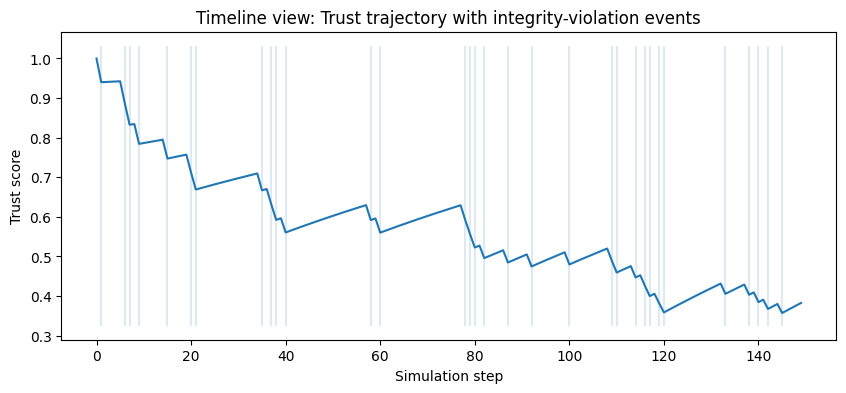

Saved: Figures/VA_Fig2_IntegrityMap.png


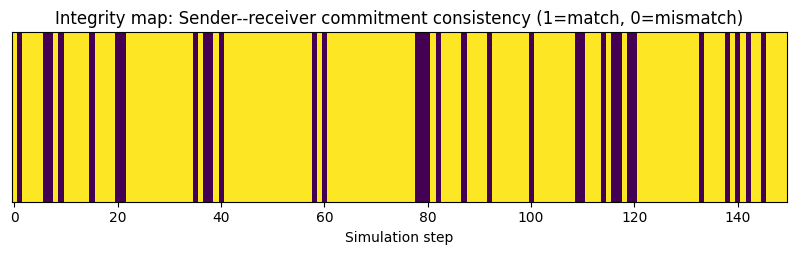

Saved: Figures/VA_Fig3_TrustLatency.png


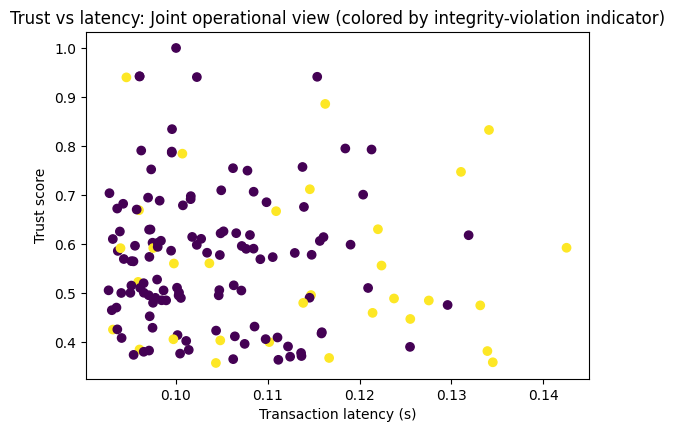

Saved: Figures/VA_Fig4_LedgerStorage.png


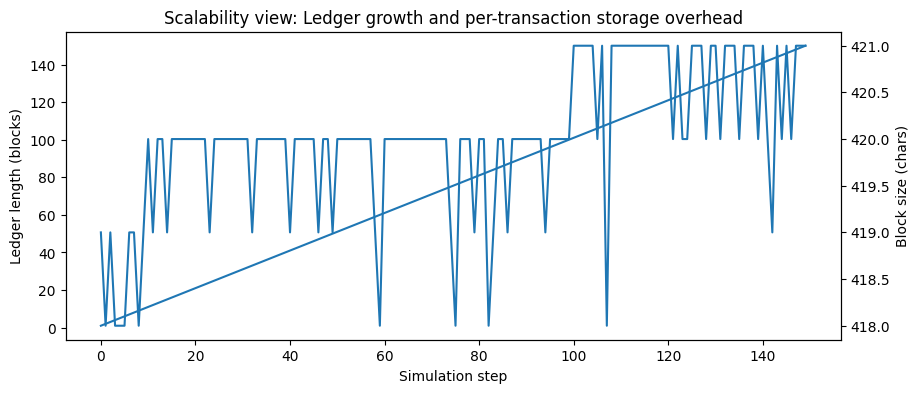

Saved: Figures/VA_Fig5_MultiDimSummary.png


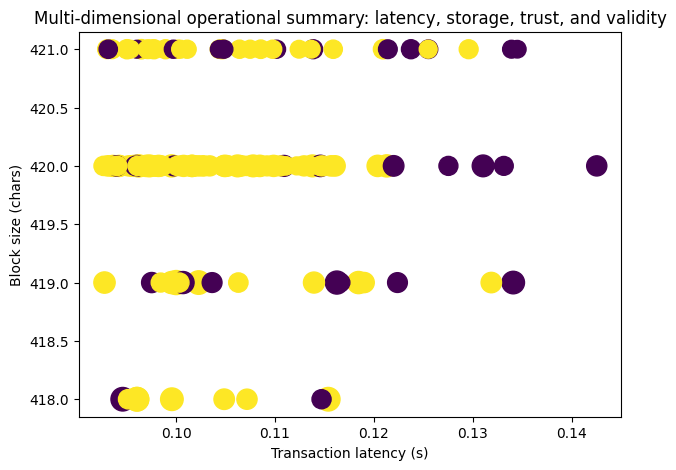

In [ ]:

# --- Visual Analytics figures (Article 2) ---
# These figures are NEW (not reused from the QS-STIN paper) and emphasize integrative interpretation.

import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("Figures", exist_ok=True)


# Ensure common columns exist (computed even if legacy figure cells are disabled)
if "block_size" not in results.columns:
    block_sizes = [len(canonical_json(b)) for b in ledger]
    results["block_size"] = block_sizes

if "latency_s" not in results.columns:
    # lightweight synthetic processing latency model (compute + serialization),
    # separate from propagation delays (which are scenario-dependent).
    base = 0.08
    bs = np.array(results["block_size"].values, dtype=float)
    lat = base + 0.00003*bs + np.abs(np.random.normal(0, 0.015, size=len(bs)))
    if "attack_flag" in results.columns:
        lat += 0.03*(results["attack_flag"].values) * (np.random.rand(len(bs)) < 0.35)
    results["latency_s"] = lat

if "block_valid" not in results.columns and "hash_match" in results.columns:
    results["block_valid"] = results["hash_match"].astype(int)



# Helper: mark attack steps on a plot
def mark_attacks(ax, steps, flags, y_top=None):
    idx = np.where(np.array(flags)==1)[0]
    if len(idx)==0:
        return
    if y_top is None:
        y_top = ax.get_ylim()[1]
    ax.vlines(idx, ymin=ax.get_ylim()[0], ymax=y_top, alpha=0.15)

# VA Fig 1: Timeline overlay (trust + attack events)
if GENERATE_VA_FIGURES:
    plt.figure(figsize=(10,4))
    ax = plt.gca()
    ax.plot(results["step"], results["trust"])
    ax.set_xlabel("Simulation step")
    ax.set_ylabel("Trust score")
    ax.set_title("Timeline view: Trust trajectory with integrity-violation events")
    # overlay attack events as vertical markers (no shading, different encoding than Article 1)
    mark_attacks(ax, results["step"].values, results["attack_flag"].values)
    savefig("VA_Fig1_TimelineTrustAttack.png")
    plt.show()

# VA Fig 2: Integrity map (hash match as a 1-row heat map)
if GENERATE_VA_FIGURES:
    plt.figure(figsize=(10,2.2))
    integrity = results["hash_match"].values.reshape(1,-1)
    plt.imshow(integrity, aspect="auto")
    plt.yticks([])
    plt.xlabel("Simulation step")
    plt.title("Integrity map: Sender--receiver commitment consistency (1=match, 0=mismatch)")
    savefig("VA_Fig2_IntegrityMap.png")
    plt.show()

# VA Fig 3: Trust vs latency (scatter; attack flag as point coloring)
if GENERATE_VA_FIGURES:
    plt.figure(figsize=(6.5,4.5))
    plt.scatter(results["latency_s"], results["trust"], c=results["attack_flag"])
    plt.xlabel("Transaction latency (s)")
    plt.ylabel("Trust score")
    plt.title("Trust vs latency: Joint operational view (colored by integrity-violation indicator)")
    savefig("VA_Fig3_TrustLatency.png")
    plt.show()

# VA Fig 4: Scalability view (ledger growth + storage overhead on twin axes)
if GENERATE_VA_FIGURES:
    plt.figure(figsize=(10,4))
    ax1 = plt.gca()
    growth = results["step"].values + 1
    ax1.plot(results["step"], growth)
    ax1.set_xlabel("Simulation step")
    ax1.set_ylabel("Ledger length (blocks)")
    ax1.set_title("Scalability view: Ledger growth and per-transaction storage overhead")
    ax2 = ax1.twinx()
    ax2.plot(results["step"], results["block_size"])
    ax2.set_ylabel("Block size (chars)")
    savefig("VA_Fig4_LedgerStorage.png")
    plt.show()

# VA Fig 5: Multi-dimensional summary (bubble plot: latency vs block size; bubble size=trust; color=validity)
if GENERATE_VA_FIGURES:
    plt.figure(figsize=(7,5))
    sizes = 80 + 220*results["trust"].values
    plt.scatter(results["latency_s"], results["block_size"], s=sizes, c=results["block_valid"])
    plt.xlabel("Transaction latency (s)")
    plt.ylabel("Block size (chars)")
    plt.title("Multi-dimensional operational summary: latency, storage, trust, and validity")
    savefig("VA_Fig5_MultiDimSummary.png")
    plt.show()
